## Transfer  Learning  of Pretrained Models

https://pytorch.org/docs/stable/torchvision/models.html

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py

https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

VGG 16-layer model (configuration “D”) with batch normalization:

https://arxiv.org/pdf/1409.1556.pdf

Inseption v3 model:

https://arxiv.org/pdf/1512.00567.pdf

https://pytorch.org/docs/stable/nn.html


Metrics:

https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

Visualization:

https://github.com/stared/livelossplot


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models

import os
import sys
import copy
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML

import sklearn
from sklearn import metrics

from livelossplot import PlotLosses

import pprint as pp

In [2]:
print('PyTorch ver.' ,  torch.__version__ )
print('torchvision ver.' ,  torchvision.__version__ )
print('cuda ver.', torch.version.cuda)
print('sckit-learn ver.', sklearn.__version__)

PyTorch ver. 1.6.0
torchvision ver. 0.7.0
cuda ver. 10.2
sckit-learn ver. 0.23.2


In [3]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import MonaLIA.model.train as train
import MonaLIA.util.visualization_helpers as visualizer
import MonaLIA.data.image_transforms
import MonaLIA.data.binary_subset

importlib.reload(MonaLIA.model.train)
#importlib.reload(MonaLIA.util.visualization_helpers)
##importlib.reload(MonaLIA.data.image_transforms)
importlib.reload(MonaLIA.data.binary_subset)

from MonaLIA.data import image_transforms
from MonaLIA.data import image_dataset

#from MonaLIA.model.train import load_net, set_optimizer, train, test, calculate_positive_weights
#from MonaLIA.model.train import decision_by_threshold, decision_by_max, decision_by_topk

from MonaLIA.data.image_dataset import JocondeDataset
from MonaLIA.data.combined_dataset import CombinedDataset
from MonaLIA.data.binary_subset import BinarySubset
from MonaLIA.data.image_transforms import NormalizeMultiCrop, PadToSquare
from MonaLIA.data.target_transforms import OneClassToOneHot

from MonaLIA.util.visualization_helpers import show_random_images, get_dataset_normalization_transformation
from MonaLIA.util.visualization_helpers import multi_label_summary as summary

### Load Data

In [8]:
dataset = 'Joconde'

if dataset == 'Joconde':
    images_root = 'C:/Joconde/joconde'
    descr_path = 'C:/Datasets/Joconde/Forty classes'
    image_description_file = os.path.join(descr_path, 'dataset1.csv')
    exclude_labels = []# ['espèce animale+être humain' , 'none+none'] 

elif dataset == 'ImageNet':
    images_root = 'Z:/Documents/Python Scripts/data/ImageNet'

else:
    raise ValueError('unknown dataset')

multi_label = True
multi_crop = False
batch_size = 4 

model_name = 'inception_v3'
model_image_size = 299
model_finetuning = True

TODO: refactor into init_dataset function

In [9]:
if model_name == 'inception_v3':
    dataset_mean =  [0.5, 0.5, 0.5]
    dataset_std  =  [0.5, 0.5, 0.5]

elif model_name == 'vgg16_bn':
    if dataset == 'Joconde':
        dataset_mean =  image_transforms.joconde_mean_animals 
        dataset_std  =  image_transforms.joconde_std_animals 
    else:
        dataset_mean =  image_transforms.imagenet_mean 
        dataset_std  =  image_transforms.imagenet_std
        
else:
    raise ValueError('unexplored model')
    
if (multi_crop):
    
    train_trans = transforms.Compose([
                    transforms.Resize(model_image_size + 32),
                    transforms.RandomHorizontalFlip(),
                    transforms.FiveCrop(model_image_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
                    NormalizeMultiCrop(mean = dataset_mean, std = dataset_std)
                    ])
    
    val_trans = transforms.Compose([
                    transforms.Resize(model_image_size + 32),
                    transforms.FiveCrop(model_image_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
                    NormalizeMultiCrop(mean = dataset_mean, std = dataset_std)
                    ])
else:

    train_trans = transforms.Compose([
        transforms.Resize(model_image_size + 32), 
        transforms.RandomResizedCrop(model_image_size),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean =  dataset_mean, std =   dataset_std ),
    ])

    val_trans = transforms.Compose([
        #transforms.Resize((model_image_size, model_image_size)), 
        transforms.Resize(model_image_size),
        transforms.CenterCrop(model_image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = dataset_mean, std = dataset_std),
    ])

if dataset == 'Joconde':
    train_set = JocondeDataset(image_description_file, 
                            images_root,
                            label_column='label',
                            exclude_labels=exclude_labels  ,
                            multiple_labels = multi_label,
                            filter_dict= {'usage': ['train']}, 
                            transform=train_trans)

    val_set = JocondeDataset(image_description_file, 
                            images_root,
                            label_column='label',
                            exclude_labels=exclude_labels  ,
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['val']}, 
                            transform=val_trans)

    test_set = JocondeDataset(image_description_file, 
                            images_root,
                            exclude_labels=exclude_labels  ,
                            label_column='label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['test']}, 
                            add_columns=['ref', 'repr'],
                            transform=val_trans)

elif dataset == 'ImageNet':
    #TODO: refactor; create a class
    train_set = dset.ImageFolder(root=os.path.join(images_root, 'train'), transform=train_trans)
    val_set = dset.ImageFolder(root=os.path.join(images_root, 'val'),  transform=val_trans)
    test_set = dset.ImageFolder(root=os.path.join(images_root, 'test'),  transform=val_trans)
    
    if multi_label:
        class_count = len(train_set.classes)
        train_set.target_transform = OneClassToOneHot(class_count)
        val_set.target_transform = OneClassToOneHot(class_count)
        test_set.target_transform = OneClassToOneHot(class_count)
        

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 drop_last = True,
                 num_workers=2)
val_loader = torch.utils.data.DataLoader(
                dataset=val_set,
                batch_size=batch_size,
                shuffle=False,
                drop_last = True,
                num_workers=2)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2)

class_count = len(train_set.classes)
class_names = train_set.classes

print('Training', train_set)
print('    Labels:', train_set.labels_count)
print()

print('Validation', val_set)
print('    Labels:',val_set.labels_count)
print()

print('Test', test_set)
print('    Labels:', test_set.labels_count)
print()


Training Dataset JocondeDataset
    Number of datapoints: 55990
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Forty classes\dataset1.csv
    Number of classes: 40
    Number of uniqie labels: 4893
    StandardTransform
Transform: Compose(
               Resize(size=331, interpolation=PIL.Image.BILINEAR)
               RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
    Labels: {'ange': 2838, 'arbre': 6647, 'armure': 1635, 'bateau': 4356, 'bateau à voiles': 1474, 'casque': 1398, 'cavalier': 2059, 'chapeau': 2395, 'cheval': 5511, 'chien': 2978, 'château': 2220, 'couronne': 2883, 'croix': 2058, 'de face': 3292, 'de profil': 4082, 'drapeau': 1132, 'draperie': 2598, 'en buste': 4628, 'feuille': 1218, 'fleur': 3848, 'lion': 1146, 'livre': 2732, 'main

TRAIN SET
('C:\\Joconde\\joconde\\0709\\m055001_0002178_p.jpg', [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '05500001718')
('C:\\Joconde\\joconde\\0677\\m021104_871-32-17_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '00000096498')
('C:\\Joconde\\joconde\\0438\\m035403_010868_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'M0354008569')
('C:\\Joconde\\joconde\\0439\\m060701_0004393_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], '06070002740')


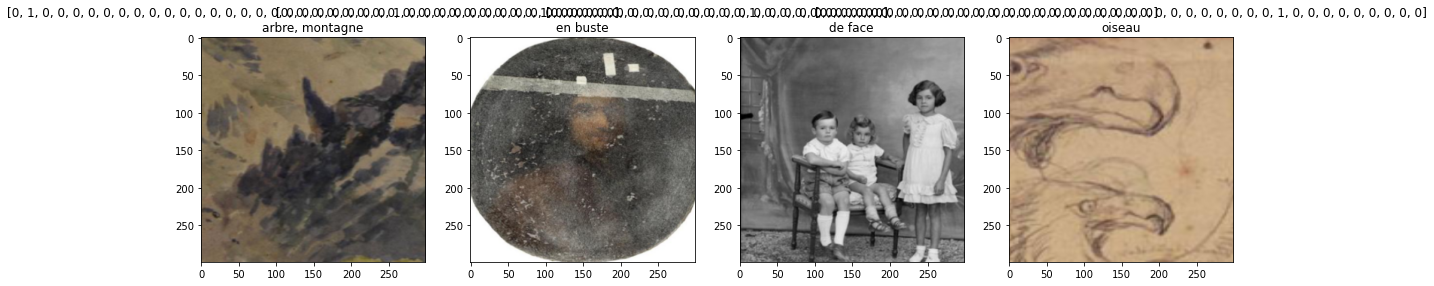

VAL SET
('C:\\Joconde\\joconde\\0397\\m505204_pe-502-photomd_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '00000076528')
('C:\\Joconde\\joconde\\0068\\m500202_atpico040521_p.jpg', [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], '5002E006766')
('C:\\Joconde\\joconde\\0482\\m101104_016208_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'M1011000632')
('C:\\Joconde\\joconde\\0050\\m105004_0001016_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], '10500006736')


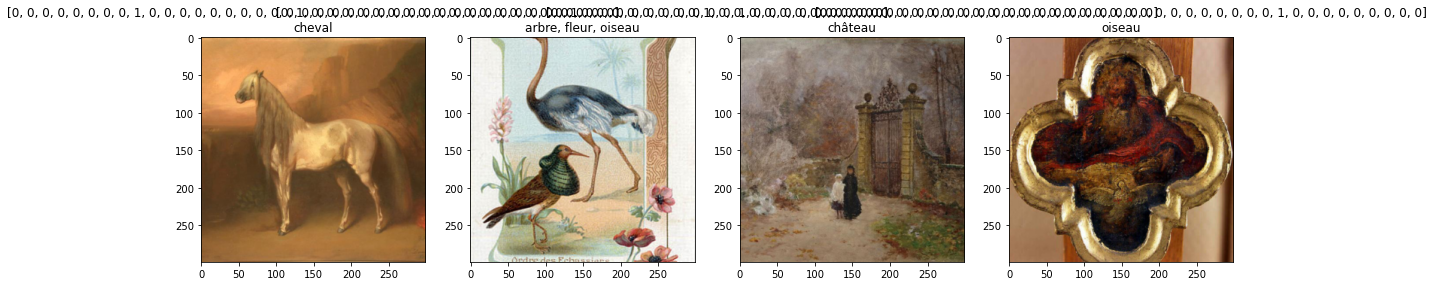

In [9]:
print('TRAIN SET')
show_random_images(train_loader.dataset, is_small=False, crop_idx=4)

print ('VAL SET')
show_random_images(val_loader.dataset,  is_small=False)

## Add external dataset(s) OPTIONAL!!! 

In [9]:
#train_set = train_loader.dataset

    
def _target_re_encoder (target, from_dataset, to_dataset):
    cls = from_dataset.classes[target]
    new_target = [0] * len(to_dataset.classes)
    new_target[train_set.class_to_idx[cls]] = 1
    return new_target

    
kaggle_images_root = '/Datasets/Kaggle'
kaggle_train_set = dset.ImageFolder(root=os.path.join(kaggle_images_root, 'train'),
                                     transform=train_set.transform)

kaggle_train_set.samples = [(image, _target_re_encoder(target, kaggle_train_set, train_set)) for (image, target) in kaggle_train_set.samples]
kaggle_train_set.targets = [s[1] for s in kaggle_train_set.samples]
kaggle_train_set.classes = train_set.classes
kaggle_train_set.class_to_idx = train_set.class_to_idx


bam_images_root = '/Datasets/BAM'
bam_train_set = dset.ImageFolder(root=os.path.join(bam_images_root, 'train'),
                                     transform=train_set.transform)
    

bam_train_set.samples = [(image, _target_re_encoder(target, bam_train_set, train_set)) for (image, target) in bam_train_set.samples]
bam_train_set.targets = [s[1] for s in bam_train_set.samples]
bam_train_set.classes = train_set.classes
bam_train_set.class_to_idx = train_set.class_to_idx

pin_images_root = '/Datasets/Pinterest'
pin_train_set = dset.ImageFolder(root=os.path.join(pin_images_root, 'train'),
                                     transform=train_set.transform)
    

pin_train_set.samples = [(image, _target_re_encoder(target, pin_train_set, train_set)) for (image, target) in pin_train_set.samples]
pin_train_set.targets = [s[1] for s in pin_train_set.samples]
pin_train_set.classes = train_set.classes
pin_train_set.class_to_idx = train_set.class_to_idx

new_train_set = CombinedDataset([train_set, kaggle_train_set, bam_train_set, pin_train_set])

train_loader = torch.utils.data.DataLoader(
                 dataset=new_train_set,
                 batch_size= batch_size,
                 shuffle=True,
                 drop_last = True,
                 num_workers= 2)

print('Combined Training', new_train_set)
print('    Labels:', new_train_set.labels_count)
print()

Combined Training Dataset CombinedDataset
    Number of datapoints: 19976
    Root location: C:/Joconde/joconde
    Root location: /Datasets/Kaggle\train
    Root location: /Datasets/BAM\train
    Root location: /Datasets/Pinterest\train
    Number of classes: 11
    Number of uniqie labels: 238
    Labels: {'arbre': 4588, 'bateau': 2460, 'chat': 1351, 'cheval': 2639, 'de profil': 3007, 'en buste': 2507, 'fleur': 2682, 'maison': 3366, 'nu': 2289, 'oiseau': 2747, 'église': 2338}



### Load Model



In [5]:
torch.cuda.is_available()

True

In [6]:
model_finetuning = True
net = train.load_net(model_name = model_name, class_count=40, finetuning = model_finetuning)

#print(net)

### Training

In [10]:
learning_rate = 0.00001

epoch_count = 20

activation = train.set_activation(torch.sigmoid)

criterion = train.set_loss_criterion(nn.BCEWithLogitsLoss(), use_weights = False,  data_loader = train_loader) # nn.CrossEntropyLoss   BCEWithLogitsLoss

optimizer = train.set_optimizer(net, optim.Adam, learning_rate = learning_rate, print_parameters= False)
    
# decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)


decision = train.decision_by_class_threshold
decision_param = 0.5

In [11]:
liveloss = PlotLosses() #(max_epoch=epoch_count , max_cols=2)
def plot_epoch (epoch_stats):
    liveloss.update(epoch_stats)
    liveloss.draw()

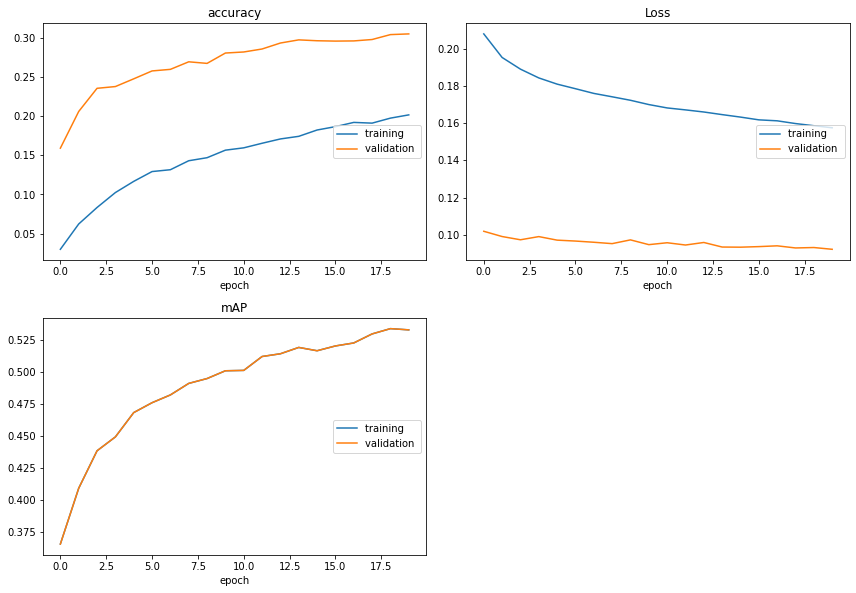

accuracy
	training         	 (min:    0.030, max:    0.202, cur:    0.202)
	validation       	 (min:    0.159, max:    0.305, cur:    0.305)
Loss
	training         	 (min:    0.158, max:    0.208, cur:    0.158)
	validation       	 (min:    0.092, max:    0.102, cur:    0.092)
mAP
	training         	 (min:    0.366, max:    0.534, cur:    0.533)
	validation       	 (min:    0.366, max:    0.534, cur:    0.533)



In [13]:
net, _, elapsed_time = train.train(net, 
                                    criterion, optimizer, scheduler, 
                                    train_loader, val_loader,  
                                    activation, decision, decision_param,
                                    save_best_model=False, 
                                    epochs_num = epoch_count,  
                                    end_of_epoch_callback=plot_epoch,
                                    checkpoint_dir = '../../MonaLIA/output',
                                    checkpoint_prefix='inception_v3_Joconde_40_classes.test.1000.4.3')

In [16]:
checkpoint_path = os.path.abspath('../../MonaLIA/output/inception_v3_Joconde_40_classes.test.1000.4.3.checkpoint.pth.tar')
checkpoint = torch.load(checkpoint_path)
print(checkpoint.keys())

dict_keys(['epoch', 'arch', 'state_dict', 'best_acc', 'classes', 'threshold', 'elapsed_time', 'metrics_history'])


In [18]:
metrics_df = pd.DataFrame(checkpoint['metrics_history'])

print('Best model training accuracy: %.4f' % metrics_df.accuracy.max())
print('Best model validation accuracy: %.4f' % metrics_df.val_accuracy.max())
print('Best model mAP: %.4f' % metrics_df.val_mAP.max())
print('Best model epoch (mAP): %d' %  (metrics_df.val_mAP.idxmax() + 1))
print('Training time: %s' % checkpoint['elapsed_time'])

Best model training accuracy: 0.2017
Best model validation accuracy: 0.3052
Best model mAP: 0.5341
Best model epoch (mAP): 19
Training time: 1 day, 3:31:16.504788


### Testing

In [20]:
activation = train.set_activation(torch.sigmoid)
decision = train.decision_by_class_threshold
decision_param = 0.5
scores = train.predict(net, test_loader, activation, decision, decision_param, print_frequency=100)

C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


images total: 100, correct: 28, acc: 28.0% , mAP: nan
images total: 200, correct: 63, acc: 31.5% , mAP: 0.596
images total: 300, correct: 94, acc: 31.3% , mAP: 0.573
images total: 400, correct: 123, acc: 30.8% , mAP: 0.546
images total: 500, correct: 150, acc: 30.0% , mAP: 0.537
images total: 600, correct: 175, acc: 29.2% , mAP: 0.532
images total: 700, correct: 199, acc: 28.4% , mAP: 0.523
images total: 800, correct: 227, acc: 28.4% , mAP: 0.521
images total: 900, correct: 259, acc: 28.8% , mAP: 0.527
images total: 1000, correct: 292, acc: 29.2% , mAP: 0.529
images total: 1100, correct: 314, acc: 28.5% , mAP: 0.522
images total: 1200, correct: 351, acc: 29.2% , mAP: 0.526
images total: 1300, correct: 383, acc: 29.5% , mAP: 0.522
images total: 1400, correct: 410, acc: 29.3% , mAP: 0.519
images total: 1500, correct: 444, acc: 29.6% , mAP: 0.520
images total: 1600, correct: 469, acc: 29.3% , mAP: 0.519
images total: 1700, correct: 499, acc: 29.4% , mAP: 0.522
images total: 1800, correct:

In [21]:
scores = scores.cpu() 
y_scores = scores.numpy()
y_true = np.array(test_loader.dataset.targets , dtype = np.dtype('B')) 
y_pred = decision(scores, decision_param).numpy().astype(np.dtype('B'))

In [22]:
prfs = metrics.precision_recall_fscore_support(y_true= y_true,
                                               y_pred= y_pred)

acc = metrics.accuracy_score(y_true= y_true,
                            y_pred= y_pred)



sim = metrics.jaccard_score(y_true= y_true,
                            y_pred= y_pred,
                            average='samples')

mAP =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores,
                                      average='macro')

In [23]:
report = metrics.classification_report(y_true= y_true,
                                 y_pred= y_pred, 
                                 target_names = test_loader.dataset.classes,
                                 output_dict = True)

ap =  metrics.average_precision_score(y_true= y_true,
                                       y_score=y_scores,
                                       average=None)

report_output = pd.concat((pd.Series([x for x in report] ),
                           pd.Series(list(train_loader.dataset.labels_count.values()) + 4 * [sum(train_loader.dataset.labels_count.values())]),
                           pd.Series(list(val_loader.dataset.labels_count.values()) + 4 * [sum(val_loader.dataset.labels_count.values())]),
                           pd.Series([x['support'] for x in report.values()]),
                           pd.Series([x['recall'] for x in report.values()]).round(3),
                           pd.Series([x['precision'] for x in report.values()]).round(3),
                           pd.Series([x['f1-score'] for x in report.values()]).round(3),
                           pd.Series(ap).round(3),
                           pd.Series(report['macro avg']['f1-score']).round(3),
                           pd.Series(acc).round(3),
                           pd.Series(mAP).round(3),
                           pd.Series(sim).round(3),
                           pd.Series(decision_param)
                           ), axis=1)
report_output.columns = ['class', 'train','val', 'support', 'recall', 'precision', 'f1-score', 'AP', 'f1 macroavg','acc', 'mAP', 'jaccard similarity score' , 'param']

report_output

C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,train,val,support,recall,precision,f1-score,AP,f1 macroavg,acc,mAP,jaccard similarity score,param
0,ange,2838,178,178,0.433,0.520,0.472,0.462,0.514,0.31,0.533,0.47,0.5
1,arbre,6647,451,451,0.612,0.624,0.618,0.638,NaN,NaN,NaN,NaN,NaN
2,armure,1635,85,85,0.612,0.460,0.525,0.566,NaN,NaN,NaN,NaN,NaN
3,bateau,4356,300,300,0.697,0.846,0.764,0.790,NaN,NaN,NaN,NaN,NaN
4,bateau à voiles,1474,102,102,0.647,0.702,0.673,0.692,NaN,NaN,NaN,NaN,NaN
5,casque,1398,63,63,0.175,0.275,0.214,0.148,NaN,NaN,NaN,NaN,NaN
6,cavalier,2059,137,137,0.380,0.460,0.416,0.456,NaN,NaN,NaN,NaN,NaN
7,chapeau,2395,153,153,0.562,0.558,0.560,0.530,NaN,NaN,NaN,NaN,NaN
8,cheval,5511,374,374,0.727,0.697,0.712,0.769,NaN,NaN,NaN,NaN,NaN
9,chien,2978,183,183,0.328,0.645,0.435,0.455,NaN,NaN,NaN,NaN,NaN


### Save Network parameters (if needed)

In [39]:
param_path = os.path.abspath('Model Parameters/inception_v3_Joconde_40_classes.test.1000.4.3.pth')
torch.save(net.state_dict(), param_path)

#### Reload Network parameters (if needed)

In [7]:
param_path = os.path.abspath('Model Parameters/inception_v3_Joconde_40_classes.test.1000.4.3.pth')
net.load_state_dict(torch.load(param_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Threshold Selection: PCut & Internal Validation

0.5


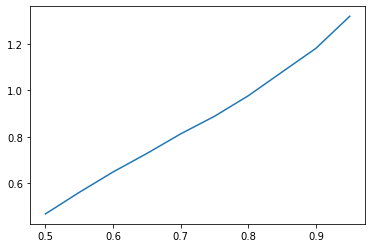

In [26]:
ths = np.arange(0.5, 1.0, 0.05, dtype = float)
scores = scores.cpu() 

train_prop = np.array(train_set.targets).sum()/len(train_set)
val_prop = np.zeros(len(ths))

for i, th in enumerate(ths):
    y_pr = scores >= th
    val_prop[i] = y_pr.sum().float() / len(test_set)

plt.plot(ths, np.abs((val_prop - train_prop)))
print(ths[np.abs(val_prop - train_prop).argmin()])

In [28]:
train.th_internal_validation(val_set, scores)

0.6000000000000001

### Visualize random test predictions

image,crop,labels,prediction
,,"[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]armurecasqueà mi-corpsportrait (Bourbon Louis Henri de, homme,à mi-corps, de trois-quarts, armure) ;tenture ; casque ; fond de paysage(ville) ; cavalerie00000075273C:\Joconde\joconde\0001\m021104_rimg0365_p.jpg",[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]armure : 1.000à mi-corps : 0.963casque : 0.816épée : 0.083de face : 0.013draperie : 0.008cheval : 0.007en buste : 0.007couronne : 0.002nudité : 0.001cavalier : 0.001nu : 0.001bateau : 0.001arbre : 0.001oiseau : 0.000chapeau : 0.000table : 0.000livre : 0.000chien : 0.000château : 0.000ange : 0.000de profil : 0.000lion : 0.000main : 0.000robe : 0.000croix : 0.000uniforme : 0.000fleur : 0.000mer : 0.000drapeau : 0.000nuage : 0.000maison : 0.000église : 0.000montagne : 0.000pont : 0.000bateau à voiles : 0.000voiture à attelage : 0.000feuille : 0.000tour : 0.000mouton : 0.000
,,"[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]croixfigure biblique (Christ en croix,Christ, croix)50350012842C:\Joconde\joconde\0195\m503501_d0012842-000_p.jpg",[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]croix : 0.999ange : 0.079cheval : 0.022de face : 0.018livre : 0.014en buste : 0.004nu : 0.003épée : 0.002à mi-corps : 0.001casque : 0.001armure : 0.001lion : 0.001nudité : 0.000main : 0.000couronne : 0.000église : 0.000oiseau : 0.000draperie : 0.000de profil : 0.000nuage : 0.000arbre : 0.000cavalier : 0.000chapeau : 0.000chien : 0.000drapeau : 0.000maison : 0.000table : 0.000château : 0.000fleur : 0.000mouton : 0.000tour : 0.000voiture à attelage : 0.000bateau : 0.000montagne : 0.000feuille : 0.000pont : 0.000uniforme : 0.000mer : 0.000robe : 0.000bateau à voiles : 0.000
,,"[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]chienscène (berger, chien, fleur orn,guirlande orn)07350000176C:\Joconde\joconde\0678\m073528_0001258_p.jpg",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]croix : 0.387couronne : 0.103fleur : 0.103lion : 0.079oiseau : 0.076drapeau : 0.072cheval : 0.050ange : 0.046épée : 0.041tour : 0.036livre : 0.014uniforme : 0.014chien : 0.013arbre : 0.013feuille : 0.012bateau : 0.008en buste : 0.006nudité : 0.006casque : 0.006de profil : 0.006nuage : 0.006cavalier : 0.004mouton : 0.004voiture à attelage : 0.004mer : 0.004nu : 0.003robe : 0.003église : 0.003draperie : 0.003chapeau : 0.003main : 0.002de face : 0.002bateau à voiles : 0.001maison : 0.001château : 0.001armure : 0.001table : 0.001à mi-corps : 0.001montagne : 0.001pont : 0.000
,,"[0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]cavalierchevalchienscène (chasseur, cavalier, bouffon,chien)02110007092C:\Joconde\joconde\0691\m021102_0003932_p.jpg",[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]cheval : 0.990cavalier : 0.974chien : 0.145arbre : 0.139maison : 0.044chapeau : 0.037voiture à attelage : 0.031église : 0.013château : 0.012montagne : 0.011oiseau : 0.011pont : 0.009épée : 0.006casque : 0.005bateau : 0.004armure : 0.003de face : 0.003drapeau : 0.003nuage : 0.003mouton : 0.003de profil : 0.002ange : 0.002croix : 0.002uniforme : 0.002mer : 0.002tour : 0.002table : 0.002fleur : 0.001nudité : 0.001nu : 0.001livre : 0.001lion : 0.001robe : 0.001draperie : 0.001couronne : 0.000bateau à voiles : 0.000en buste : 0.000main : 0.000à mi-corps : 0.000feuille : 0.000
,,"[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]chevalvoiture à attelagevue d'architecture (Bordeaux, théâtre,nuit, voiture à attelage : cheval) ;figure (femme, de dos, nuit)5002E011646C:\Joconde\joconde\0654\m500202_atpico050713_p.jpg",[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]cheval : 0.720cavalier : 0.551voiture à attelage : 0.276chien : 0.191drapeau : 0.059château
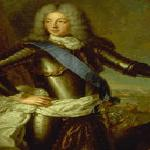
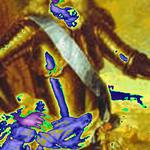
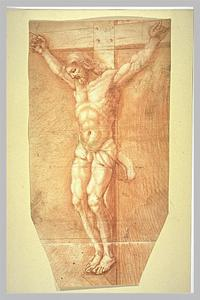
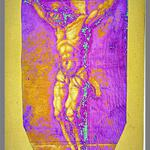
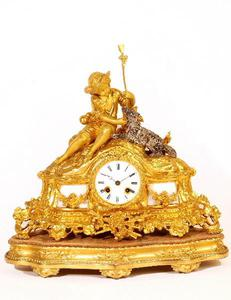
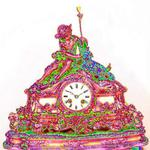
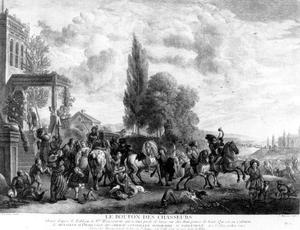
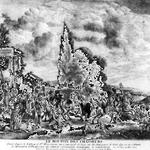
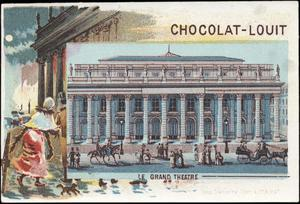
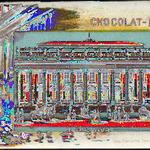

In [30]:
rows = 5
#y_pred_v =decision(scores, decision_param).numpy()
   
#testset_idx_pick = np.arange(rows)    
testset_idx_pick = np.random.randint(0, len(test_loader.dataset.samples), size=rows)

HTML(visualizer.visualize_classification_HTML(test_loader.dataset, y_pred, y_scores, testset_idx_pick))

## Scrapbook

In [ ]:
def myCrossEntropyLoss(outputs, labels):
    batch_size = outputs.size()[0]            # batch_size
    outputs = F.log_softmax(outputs, dim=1)   # compute the log of softmax values
    outputs = outputs[range(batch_size), labels] # pick the values corresponding to the labels
    return -torch.sum(outputs)/num_examples

In [ ]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs==labels)/float(labels.size)